<a href="https://colab.research.google.com/github/bahbo/SoftUni_Data_Scinece/blob/main/Final%20project/main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
%matplotlib inline

In [ ]:
import pandas as pd
import numpy as np
import holidays
import time
import datetime
from dateutil.relativedelta import relativedelta
from dateutil.rrule import rrule, MONTHLY
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm


from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


&emsp; В настоящата разработка ще съставим модел за прогнозиране на краткорочното потреблението на електроенергия в България. Такъв модел би бил полезен за целия енергиен сектор - прозводители, търговци, доставчици и регулаторни органи.  Прогнозирането на потреблението е необходим защото електричеството трябва да се генерира в момента, в който се използва. Прогнозите помагат на електроенергийните компании да разберат колко енергия ще бъде нужна в различни части на деня, за да могат да балансират товара и да предотвратят прекомерно зареждане или недостиг. (Повече информация за енергийната система на https://ateb.bg/%d0%bf%d0%b0%d0%b7%d0%b0%d1%80/ ).



Прогнозата за се изчислява въз основа на историческия профил на товара
, като се взимат предвид променливите, които влияят на търсенето на електроенергия, като например метеорологични условия, климат и социално-икономически фактори. (източник https://transparency.entsoe.eu/content/static_content/Static%20content/knowledge%20base/data-views/load-domain/Data-view%20Total%20Load%20-%20Day%20Ahead%20-%20Actual.html )


Даните които ще използвам са историческа информация за потреблението на електроенергия по часове (виж energy.ipynb) и историческа информация за 3 климатични показателя (виж meteo.ipynb).

In [ ]:
meteo = pd.read_csv("/content/drive/My Drive/Colab Notebooks/data/meteo_data.csv", index_col=False)
meteo

,time,temperature,precipitation,air_pressure
0,2020-01-01 00:00:00,0.5,0.0,1023.3
1,2020-01-01 01:00:00,0.3,0.0,1023.7
2,2020-01-01 02:00:00,-0.1,0.0,1024.2
3,2020-01-01 03:00:00,-0.4,0.0,1024.6
4,2020-01-01 04:00:00,-0.7,0.0,1025.1
...,...,...,...,...
31987,2023-08-25 19:00:00,25.9,0.0,1014.5
31988,2023-08-25 20:00:00,25.1,0.0,1014.8
31989,2023-08-25 21:00:00,24.3,0.0,1015.1
31990,2023-08-25 22:00:00,23.7,0.0,1015.2


In [ ]:
energy = pd.read_csv("/content/drive/My Drive/Colab Notebooks/data/energy_data.csv", index_col=False)
energy

,Hour,Total_Load_MW,Day
0,1,4063,2020-01-01 00:00:00
1,2,3924,2020-01-01 01:00:00
2,3,3838,2020-01-01 02:00:00
3,4,3795,2020-01-01 03:00:00
4,5,3800,2020-01-01 04:00:00
...,...,...,...
31951,20,4008,2023-08-24 19:00:00
31952,21,3664,2023-08-24 20:00:00
31953,22,3435,2023-08-24 21:00:00
31954,23,3224,2023-08-24 22:00:00


В двата набора от данни няма липсващи стойности и колоните Day и time са в UTC време.

In [ ]:
data = pd.merge(energy, meteo, left_on="Day", right_on="time")
data = data[["Day","Hour","temperature","precipitation", "air_pressure", "Total_Load_MW"]]
data["Day"] = pd.to_datetime(data["Day"])
data

,Day,Hour,temperature,precipitation,air_pressure,Total_Load_MW
0,2020-01-01 00:00:00,1,0.5,0.0,1023.3,4063
1,2020-01-01 01:00:00,2,0.3,0.0,1023.7,3924
2,2020-01-01 02:00:00,3,-0.1,0.0,1024.2,3838
3,2020-01-01 03:00:00,4,-0.4,0.0,1024.6,3795
4,2020-01-01 04:00:00,5,-0.7,0.0,1025.1,3800
...,...,...,...,...,...,...
31951,2023-08-24 19:00:00,20,25.1,0.0,1015.3,4008
31952,2023-08-24 20:00:00,21,24.4,0.0,1015.3,3664
31953,2023-08-24 21:00:00,22,23.8,0.0,1015.4,3435
31954,2023-08-24 22:00:00,23,23.2,0.0,1015.3,3224


In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 31956 entries, 0 to 31955
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   Day            31956 non-null  datetime64[ns]
 1   Hour           31956 non-null  int64         
 2   temperature    31956 non-null  float64       
 3   precipitation  31956 non-null  float64       
 4   air_pressure   31956 non-null  float64       
 5   Total_Load_MW  31956 non-null  int64         
dtypes: datetime64[ns](1), float64(3), int64(2)
memory usage: 1.7 MB


In [ ]:
data.describe().T

,count,mean,std,min,25%,50%,75%,max
Hour,31956.0,11.497278,6.922606,0.0,5.0,11.0,17.0,23.0
temperature,31956.0,13.570059,9.080111,-8.2,6.0,13.0,20.9,36.8
precipitation,31956.0,0.062398,0.150549,0.0,0.0,0.0,0.0,2.2
air_pressure,31956.0,1017.015959,7.341494,993.8,1012.1,1016.1,1021.6,1044.2
Total_Load_MW,31956.0,4255.797252,857.143861,2432.0,3662.0,4145.0,4790.0,7198.0


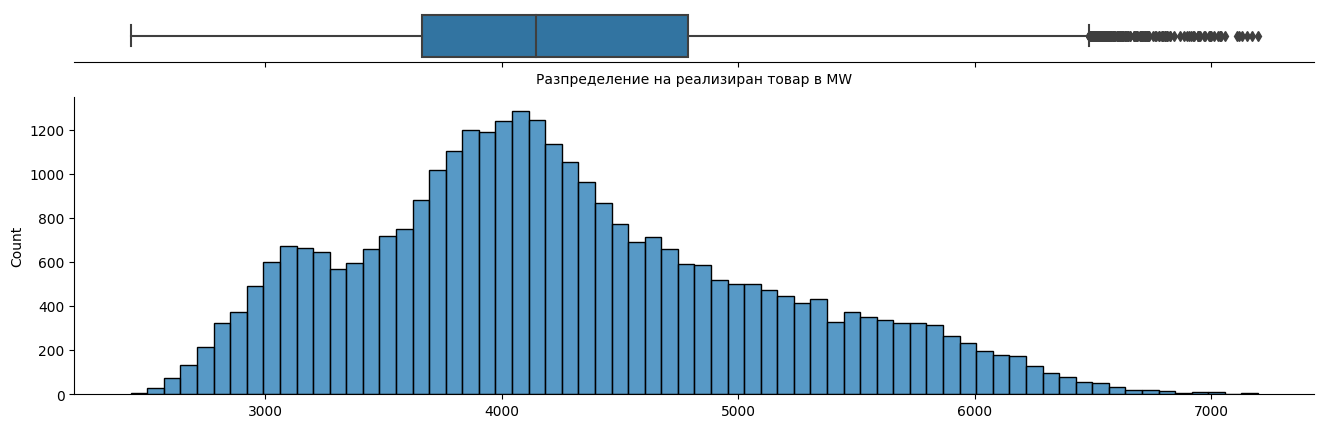

In [ ]:
f, (ax_box, ax_hist) = plt.subplots(2, sharex=True, gridspec_kw={"height_ratios": (.15, .85)},figsize=(16,5))

sns.boxplot(x=data["Total_Load_MW"], ax=ax_box)
sns.histplot(x=data["Total_Load_MW"], ax=ax_hist)

ax_box.set(yticks=[],xlabel="Разпределение на реализиран товар в MW")
ax_hist.set(xlabel=None)
sns.despine(ax=ax_hist)
sns.despine(ax=ax_box, left=True)


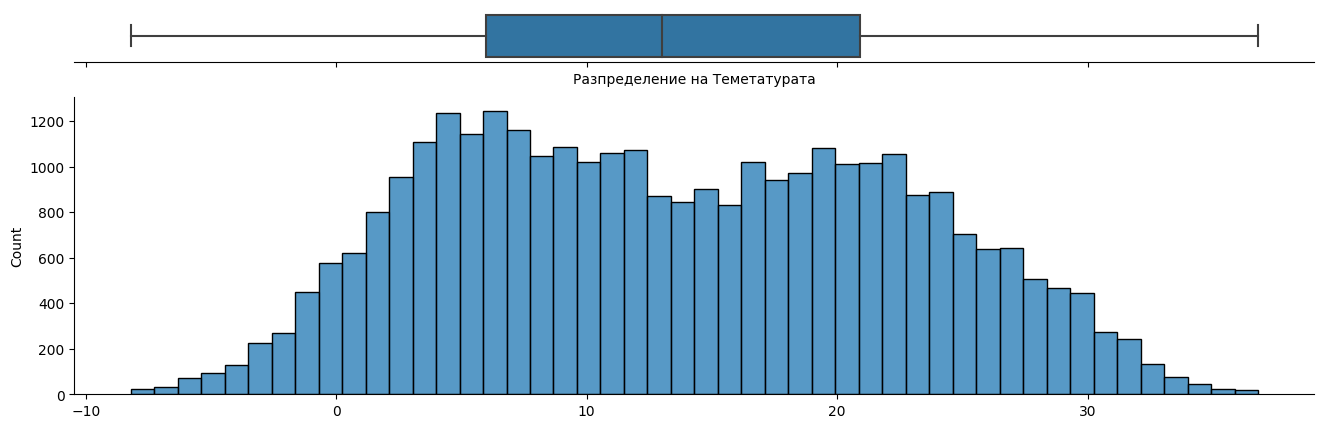

In [ ]:
f, (ax_box, ax_hist) = plt.subplots(2, sharex=True, gridspec_kw={"height_ratios": (.15, .85)},figsize=(16,5))

sns.boxplot(x=data["temperature"], ax=ax_box)
sns.histplot(x=data["temperature"], ax=ax_hist)

ax_box.set(yticks=[],xlabel="Разпределение на Теметатурата")
ax_hist.set(xlabel=None)
sns.despine(ax=ax_hist)
sns.despine(ax=ax_box, left=True)

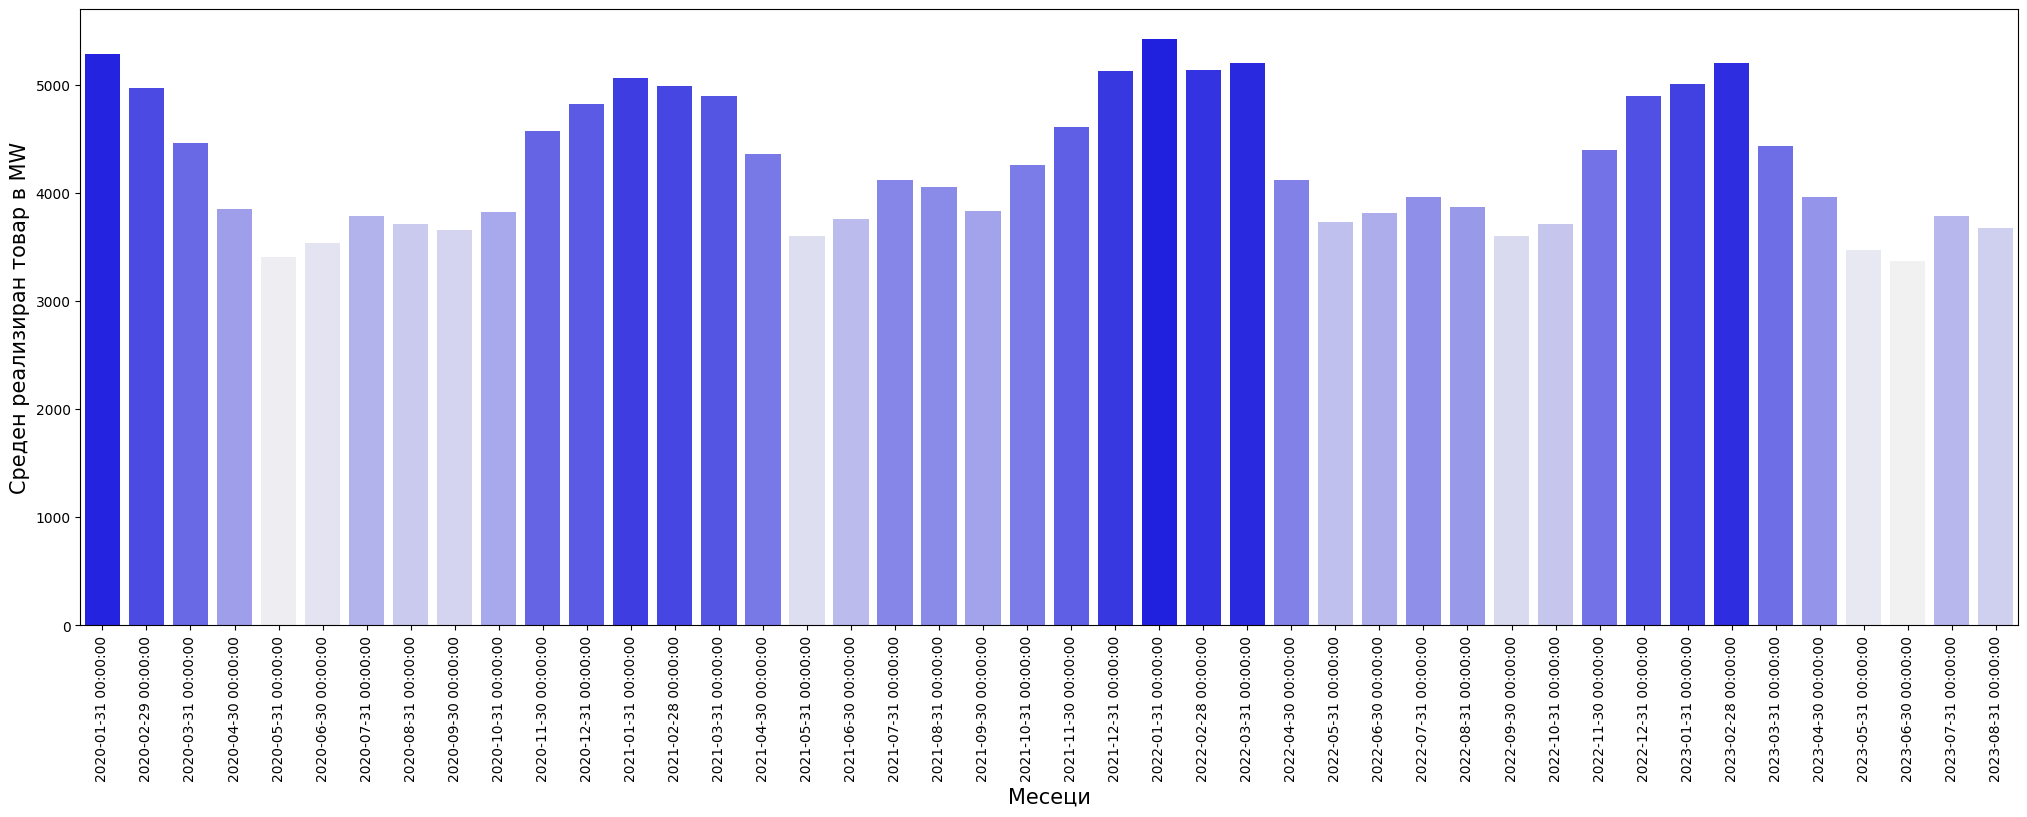

In [ ]:
# Среден реализиран товар в MW по месеци
grop_by_month = data.groupby(pd.Grouper(key="Day", freq="M")).mean(numeric_only=True)

plt.figure(figsize=(25,8))
plot = sns.barplot(y="Total_Load_MW", x=grop_by_month.index, hue="Total_Load_MW", data=grop_by_month, dodge=False, color="blue").legend_.remove()
plt.xlabel("Месеци",fontsize=15)
plt.xticks(rotation=90)
plt.ylabel("Среден реализиран товар в MW",fontsize=15)
plt.show()

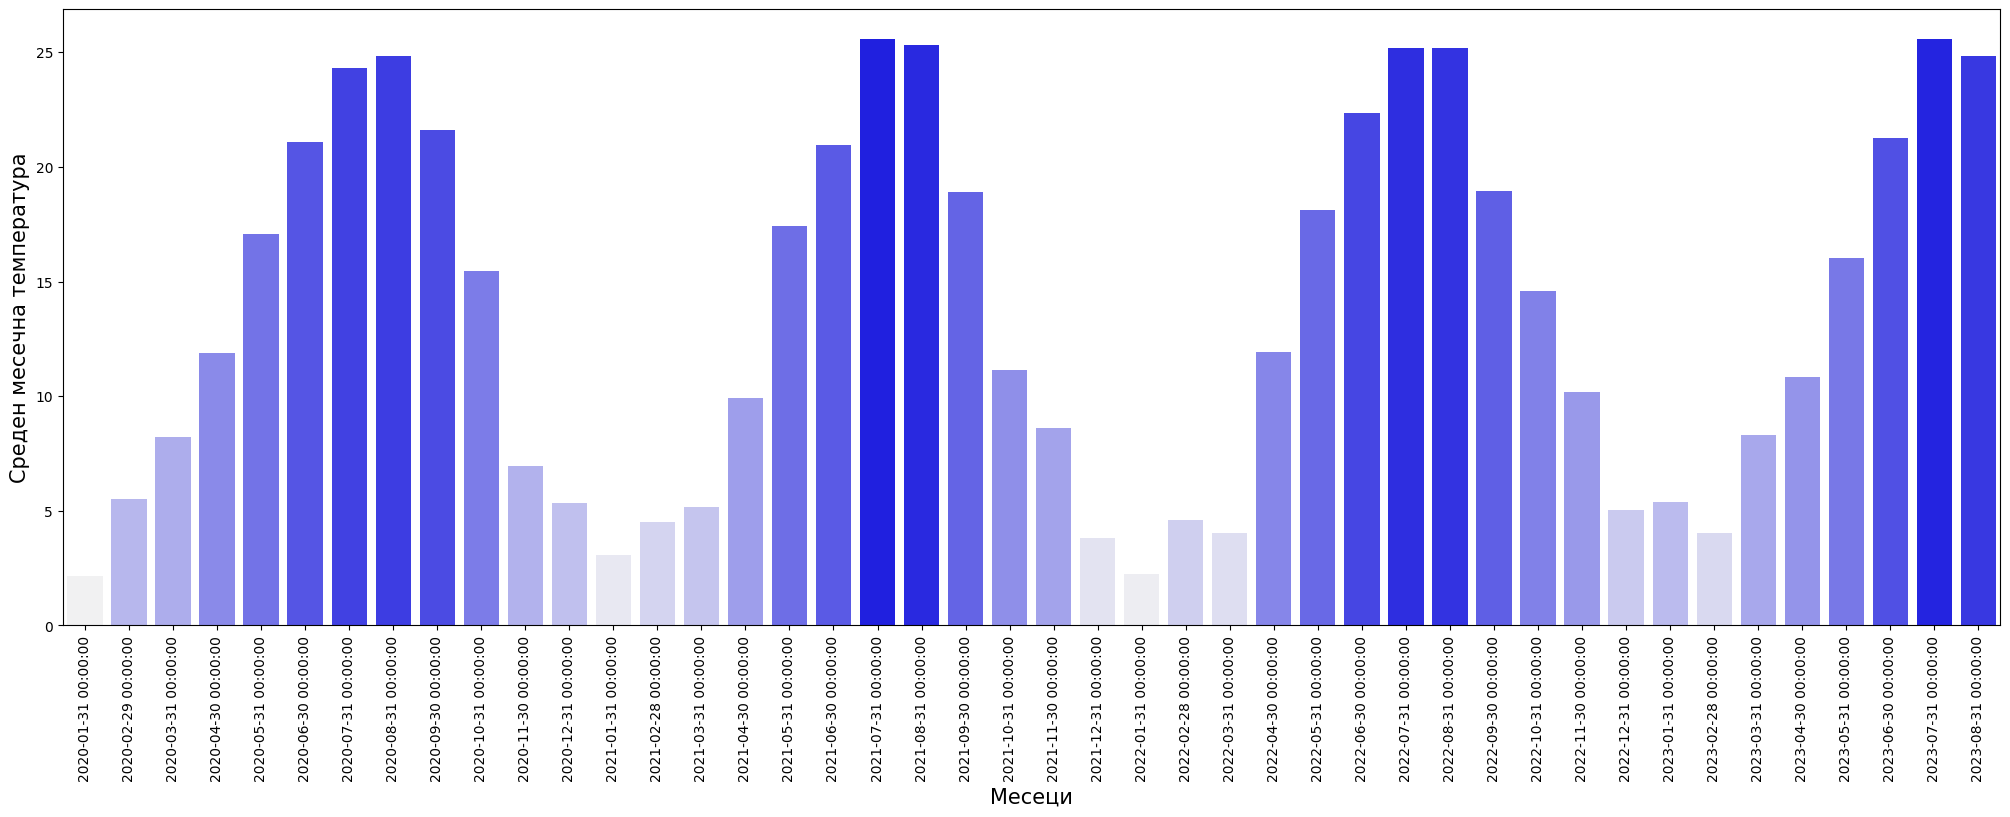

In [ ]:
# Среден температура по месеци
grop_by_month = data.groupby(pd.Grouper(key="Day", freq="M")).mean(numeric_only=True)

plt.figure(figsize=(25,8))
plot = sns.barplot(y="temperature", x=grop_by_month.index, hue="temperature", data=grop_by_month, dodge=False, color="blue").legend_.remove()
plt.xlabel("Месеци",fontsize=15)
plt.xticks(rotation=90)
plt.ylabel("Среден месечна температура",fontsize=15)
plt.show()

В студените месеци потреблението на електроенергия е по голомо от топлите.

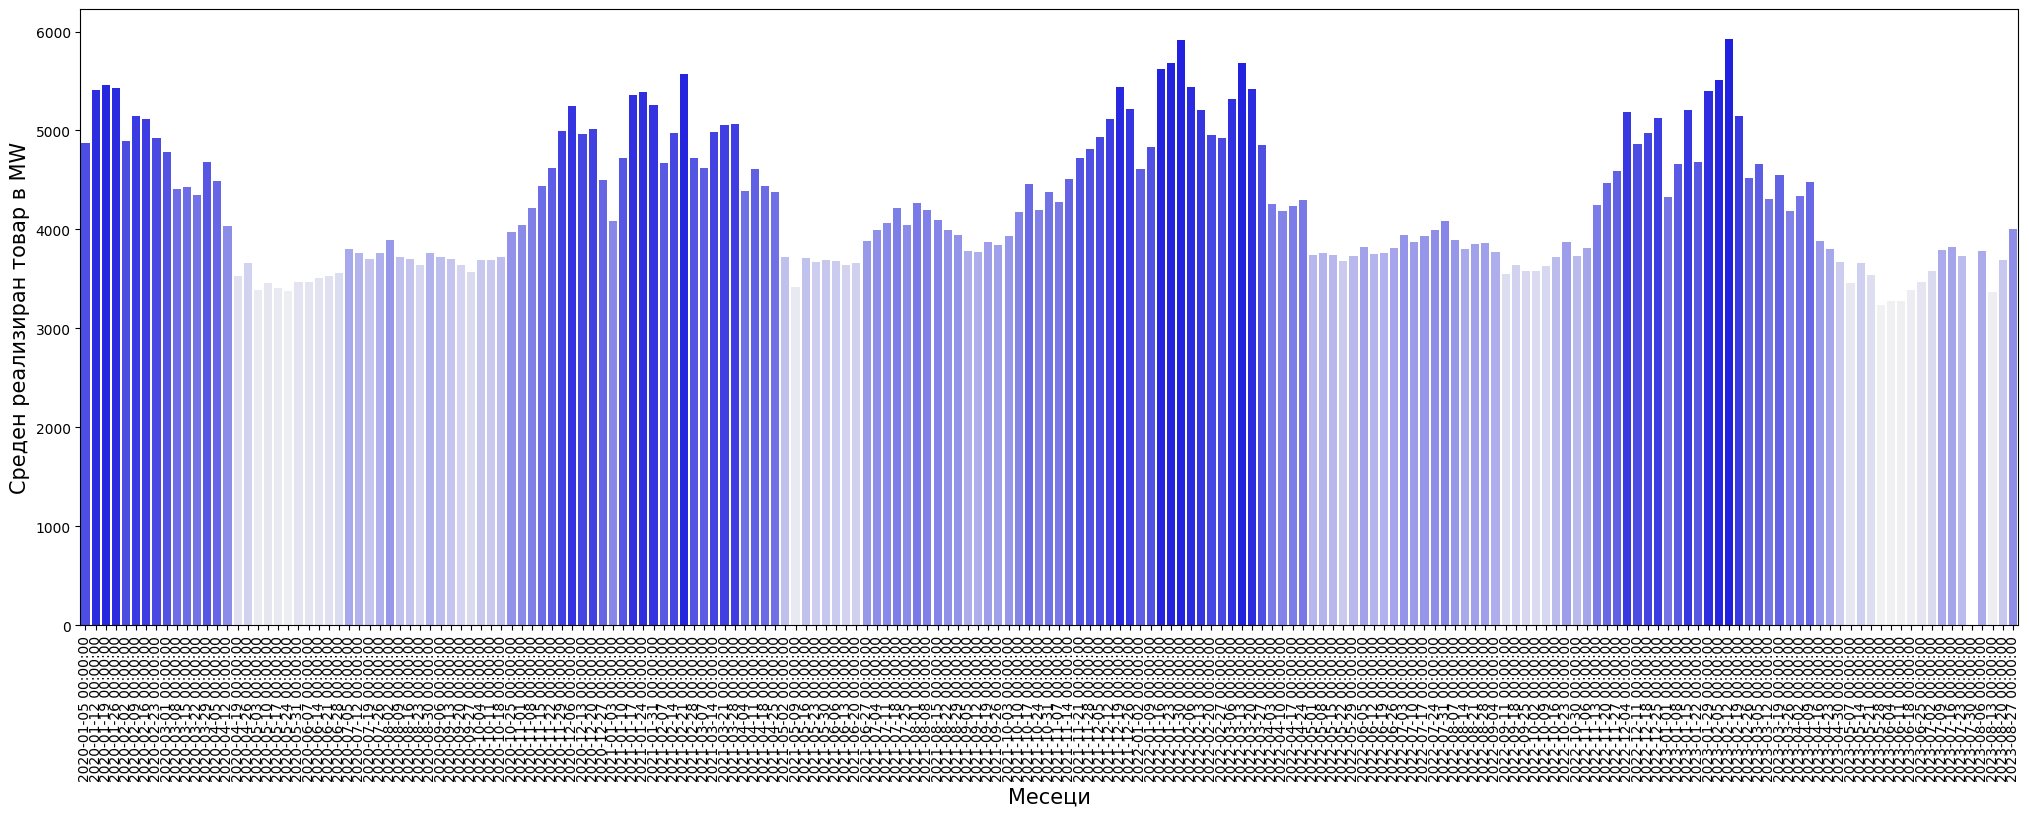

In [ ]:
# Среден реализиран товар в MW по седмиц
grop_by_week = data.groupby(pd.Grouper(key="Day", freq="W")).mean(numeric_only=True)

plt.figure(figsize=(25,8))
plot = sns.barplot(y="Total_Load_MW", x=grop_by_week.index, hue="Total_Load_MW", data=grop_by_week, dodge=False, color="blue").legend_.remove()
plt.xlabel("Месеци",fontsize=15)
plt.xticks(rotation=90)
plt.ylabel("Среден реализиран товар в MW",fontsize=15)
plt.show()

Прави впечатление ниски стойности за използваната електроенер в седмиците 2020-05-03, 2020-05-24, 2020-05-09 и по Нова година. Ще направя проверка за почивните и празничните дни имат отнощение за потреблението на електроенерги.

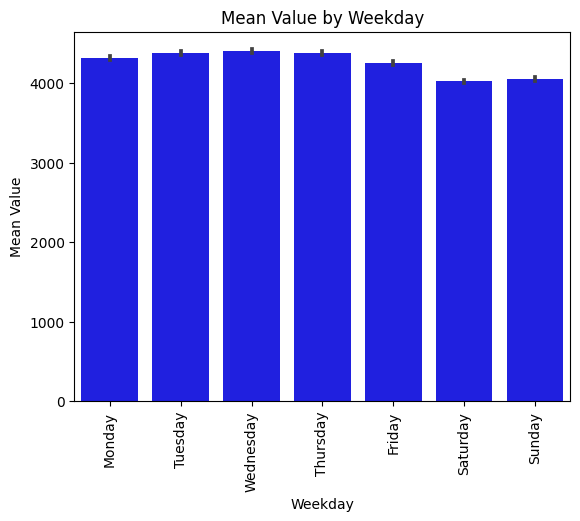

In [ ]:
data["Weekday"] = data["Day"].dt.strftime('%A')

categories = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]
data["Weekday"] = pd.Categorical(data["Weekday"], categories=categories, ordered=True)

sns.barplot(x="Weekday", y="Total_Load_MW", data=data, color="blue")
plt.ylabel('Mean Value')
plt.xlabel('Weekday')
plt.title('Mean Value by Weekday')
plt.xticks(rotation=90)
plt.show()


Изглежда потреблението пред почивните дни е по-малко.

In [ ]:
# Колоната "Weekday" ще стане категорийна за работен / почивен ден
data["Weekday"] = data["Day"].dt.dayofweek

data.loc[data["Weekday"] < 5, "Weekday"] = 1
data.loc[data["Weekday"] != 1, "Weekday"] = 0
data.rename(columns={"Weekday":"Business_day"}, inplace=True)
data

,Day,Hour,temperature,precipitation,air_pressure,Total_Load_MW,Business_day
0,2020-01-01 00:00:00,1,0.5,0.0,1023.3,4063,1
1,2020-01-01 01:00:00,2,0.3,0.0,1023.7,3924,1
2,2020-01-01 02:00:00,3,-0.1,0.0,1024.2,3838,1
3,2020-01-01 03:00:00,4,-0.4,0.0,1024.6,3795,1
4,2020-01-01 04:00:00,5,-0.7,0.0,1025.1,3800,1
...,...,...,...,...,...,...,...
31951,2023-08-24 19:00:00,20,25.1,0.0,1015.3,4008,1
31952,2023-08-24 20:00:00,21,24.4,0.0,1015.3,3664,1
31953,2023-08-24 21:00:00,22,23.8,0.0,1015.4,3435,1
31954,2023-08-24 22:00:00,23,23.2,0.0,1015.3,3224,1


In [ ]:
# Съставяне на списък с почивните дни (от библиотеката "holidays") за периада на извадката. Проверено и отговаря на изискванията за почивни дни по Чл. 154 от КТ.
current_year = datetime.datetime.today().year

years = list(range(2020, current_year + 1))

bg_holidays = [day[0] for day in holidays.BG(years).items()]
bg_holidays

data.loc[(data['Day'].isin(bg_holidays)) & (data["Business_day"] != 0), 'Business_day'] = 2

data.head()

,Day,Hour,temperature,precipitation,air_pressure,Total_Load_MW,Business_day
0,2020-01-01 00:00:00,1,0.5,0.0,1023.3,4063,2
1,2020-01-01 01:00:00,2,0.3,0.0,1023.7,3924,1
2,2020-01-01 02:00:00,3,-0.1,0.0,1024.2,3838,1
3,2020-01-01 03:00:00,4,-0.4,0.0,1024.6,3795,1
4,2020-01-01 04:00:00,5,-0.7,0.0,1025.1,3800,1


In [ ]:
#Три стойности: 0 - Събота или Неделя, 1 - работен ден, 3 - празничен ден
data["Business_day"].unique()

array([2, 1, 0])

Доста ме е срам, но за съжаление тук преключва анализа. Не успях да покажа всичко, което исках но смятам да го довърша проекта напред във времето.

Благодаря за вниманието.